In [1]:
# Import the libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# Settings the figsize parameter for the plots in this notebook to standardize the size of plots
plt.rcParams["figure.figsize"] = (15, 8)

In [3]:
def download_daily_data(ticker,start,end):
    """
    The function downloads daily market data to a pandas DataFrame using yfinance API between the dates specified
    """
    data = yf.download(ticker, start, end,auto_adjust = False)

    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(1)
    ## The above code remove the index 1 from multiple index which makes accessing the data easy
    desired_columns = ['Open','High','Low','Close','Adj Close','Volume']
    ## Filtering and reordering columns into desired results
    data = data[[col for col in desired_columns if col in data.columns]]
    # Remove the name of the column index (e.g., 'Price') for cleaner output.
    data.columns.name = None
  
    return data


In [4]:

ticker2 = "RELIANCE.NS" ## Nifty 50
end2 = datetime.date(2025, 8, 15)
## Data taken from 2019 august to incompensate the effective ness of strategy during covid and after covid
start2 = end2 - pd.Timedelta(days=365*6)
reliance = download_daily_data(ticker2,start2,end2)

[*********************100%***********************]  1 of 1 completed


In [5]:
reliance

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-19,585.652954,592.853333,585.172913,590.933228,578.248596,16317602
2019-08-20,589.653198,590.933228,581.789917,583.321411,570.800171,14969299
2019-08-21,583.184265,584.555786,579.001221,581.035583,568.563477,10677848
2019-08-22,581.035583,581.058411,566.383423,569.972168,557.737549,14031953
2019-08-23,566.429138,587.001587,560.714539,583.275696,570.755493,21307915
...,...,...,...,...,...,...
2025-08-08,1385.000000,1397.199951,1365.000000,1367.800049,1362.358887,8793606
2025-08-11,1370.000000,1388.000000,1361.199951,1386.199951,1380.685669,9997486
2025-08-12,1381.900024,1401.900024,1375.199951,1380.400024,1374.908813,12244664


## Computing Returns

In [6]:
reliance['returns'] = reliance['Close'].pct_change()
reliance['returns'] = reliance['returns'].dropna()

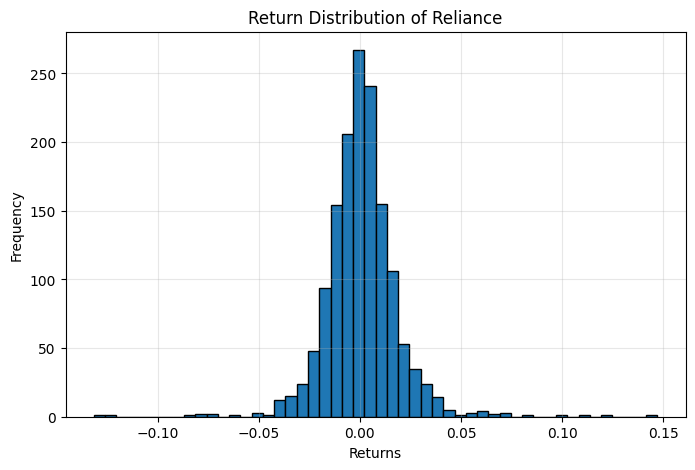

In [7]:
# Ploting the histogram of returns
plt.figure(figsize=(8,5))
plt.hist(reliance['returns'], bins=50, edgecolor='black')  # bins can be tuned
plt.title('Return Distribution of Reliance')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
## Computing mean, standard deviation and annulaized returns of returns
mean_returns = reliance['returns'].mean()
std_returns = reliance['returns'].std()

## Annualized Mean 
Annualized_Mean = (1 + mean_returns)**252 - 1
Annualized_Std  = std_returns * np.sqrt(252)

## Annualized Variance
annualized_variance = (std_returns ** 2) * 252

from scipy.stats import skew,kurtosis
returns_no_na = reliance['returns'].dropna()
returns_skewness = skew(returns_no_na)
returns_kurtosis = kurtosis(returns_no_na)

print("Mean Returns",mean_returns)
print("Standard Deviation Returns",std_returns)
print("Annualized Mean Returns",Annualized_Mean)
print("Annualized Standard Deviation Returns",Annualized_Std)
print("Annualized Variance:", annualized_variance)
print("Skewness:", returns_skewness)
print("Excess Kurtosis:", returns_kurtosis)

Mean Returns 0.000731850253196117
Standard Deviation Returns 0.018079639373356
Annualized Mean Returns 0.20244719639277053
Annualized Standard Deviation Returns 0.2870053774537898
Annualized Variance: 0.08237208668739235
Skewness: 0.37072733762330834
Excess Kurtosis: 10.407634340376713


## Checking for Noramlity using teh Shapiro-Wilk test 

In [9]:
from scipy.stats import shapiro
# Shapiro–Wilk test
stat, p_value = shapiro(returns_no_na)

print("Shapiro-Wilk Test Statistic:", stat)
print("p-value:", p_value)

# Print the results
if p_value <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Shapiro-Wilk Test Statistic: 0.8988801517043501
p-value: 3.4710920447918856e-30
Null hypothesis of normality is rejected.


## Caculating Historical VaR and C-VaR(Expected Shortfall)
Value at Risk (VaR) is the maximum loss that one will not exceed with a certain probability α within a given time horizon. It is given as a threshold with a given confidence level that losses will not exceed at that level.

Conditional Value at Risk (CVaR), or Expected Shortfall, is an estimate of expected losses sustained in the worst (1 - x)% of scenarios.

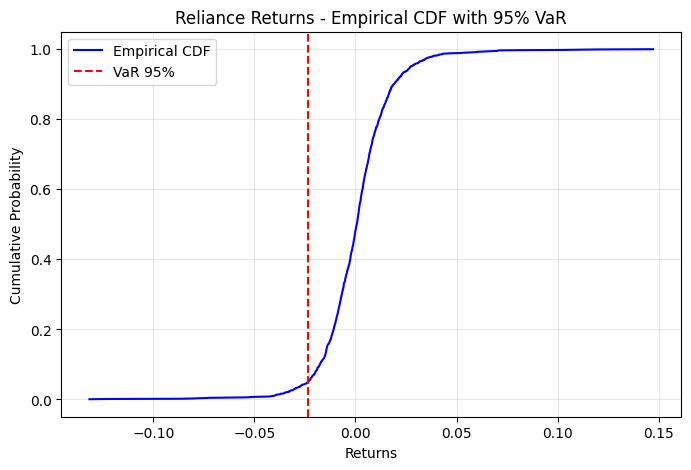

-0.02323237626738892


In [10]:
# Define the var level parameter
var_level = 0.95
alpha = 1 - var_level

# Sort the returns for plotting
sorted_returns = np.sort(returns_no_na)

## This is allowing us to see the cumulative distribution function & its probability curve
# Plot the probability of each sorted return quantile
prob = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)

# Compute and print the historical VaR
VaR95 = np.percentile(sorted_returns,alpha * 100)



# Draw a vertical line in the plot for the VaR 95 quantile
plt.figure(figsize=(8,5))
plt.plot(sorted_returns, prob, label='Empirical CDF', color='blue')
plt.axvline(x=VaR95, color='red', linestyle='--', label=f'VaR {var_level*100:.0f}%')
plt.title(f'Reliance Returns - Empirical CDF with {var_level*100:.0f}% VaR')
plt.xlabel('Returns')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print(VaR95)

## Calculating the CVaR
The average loss given that the loss has already exceeded the VaR level.

In [11]:
# Compute and print the expected shortfall
CVaR95 = returns_no_na[returns_no_na <= VaR95].mean()

print(f"VaR 95%: {VaR95}")
print(f"CVaR 95% (Expected Shortfall): {CVaR95}")

VaR 95%: -0.02323237626738892
CVaR 95% (Expected Shortfall): -0.038098166519338054


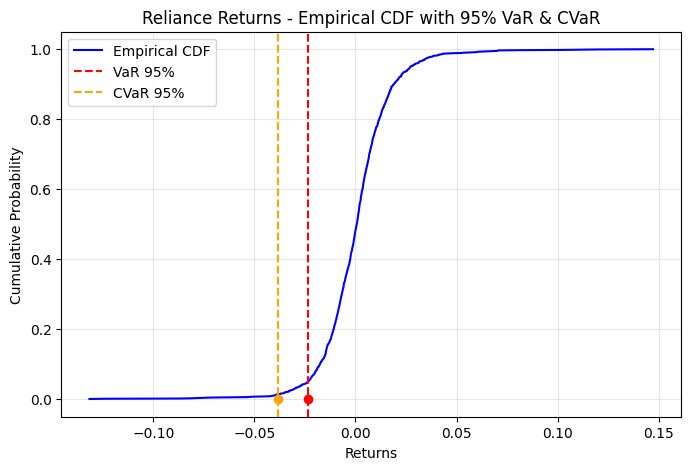

In [12]:
# Draw vertical lines in the plot for the VaR 95 and CVaR quantiles
plt.figure(figsize=(8,5))
plt.plot(sorted_returns, prob, label='Empirical CDF', color='blue')

# VaR vertical line
plt.axvline(x=VaR95, color='red', linestyle='--', label=f'VaR {var_level*100:.0f}%')

# CVaR vertical line
plt.axvline(x=CVaR95, color='orange', linestyle='--', label=f'CVaR {var_level*100:.0f}%')

# Highlight both on x-axis
plt.scatter(VaR95, 0, color='red', zorder=5)
plt.scatter(CVaR95, 0, color='orange', zorder=5)
plt.title(f'Reliance Returns - Empirical CDF with {var_level*100:.0f}% VaR & CVaR')
plt.xlabel('Returns')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Calculating the Parametric VaR and CVaR (Expected Shortfall)
The parametric method VAR (also known as Variance/Covariance VAR) calculation is another commonly used form of VaR calculation. This method allows you to simulate a range of possibilities based on historical return distribution properties rather than actual return values.
- Parametric VaR=μ+σ⋅zα
- Parametric CVaR = μ−σ⋅φ(zα)/α, φ = normal PDF

In [13]:
from scipy.stats import norm
# Set the confidence level for VaR(95)
confidence_interval = 0.95
# Set the significance level
significance_level = 1 - confidence_interval
# Calculate the parametric VaR(95)(Normal Distribution)
#PPF – Percent Point Function
#The PPF is the inverse of the cumulative distribution function (CDF).
#It gives you the value (quantile) corresponding to a given probability level
PVaR95 = mean_returns + std_returns * norm.ppf(significance_level)
# Calculate the parametric CVaR(95)
#The PDF describes how probability is distributed across possible values of a continuous random variable.
PCVaR = mean_returns + std_returns * (norm.pdf(norm.ppf(significance_level))/significance_level)

print(f"Mean daily return: {mean_returns}")
print(f"Std daily return: {std_returns}")
print(f"Parametric VaR 95%: {PVaR95}")
print(f"Parametric CVaR 95%: {PCVaR}")

Mean daily return: 0.000731850253196117
Std daily return: 0.018079639373356
Parametric VaR 95%: -0.029006510144043145
Parametric CVaR 95%: 0.038024953943733064


## Scaling the VaR
To estimate the VaR for a longer time duration, scale the value by the square root of time, similar to scaling volatility.
Formula: 
$\text{VaR}_{\text{t days}} = \text{VaR}_{\text{1 day}} * \sqrt{t}$

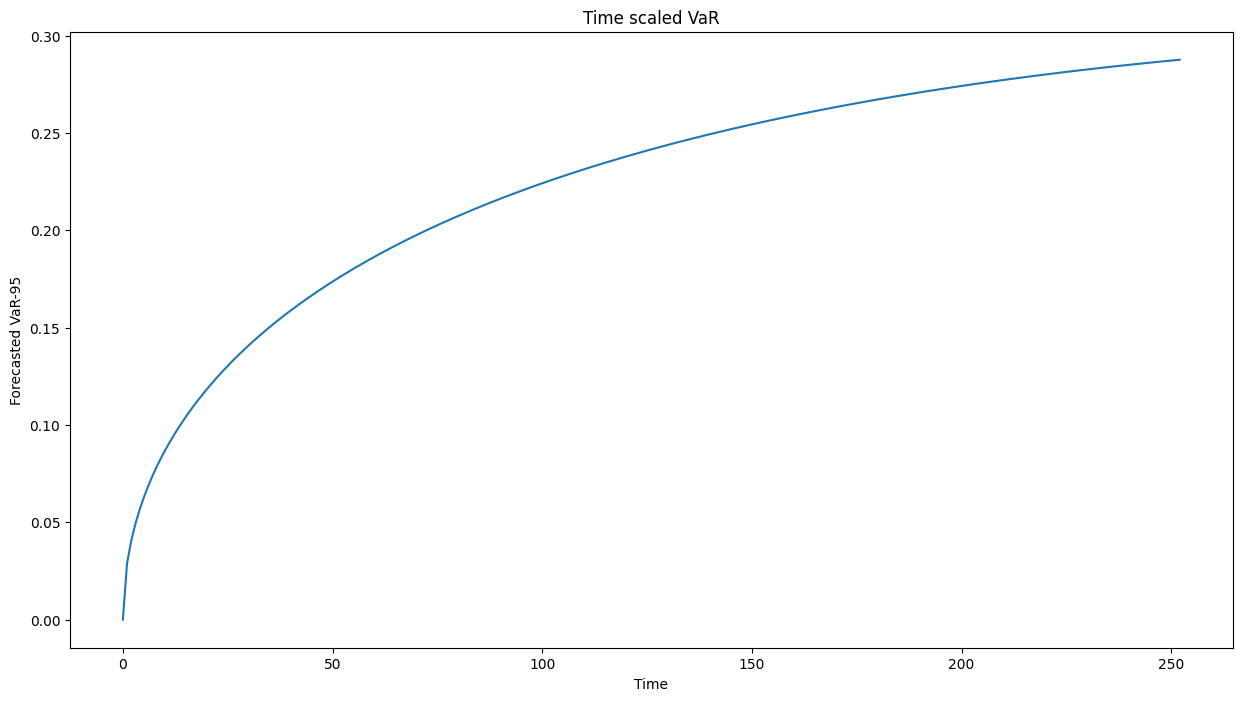

In [14]:
## Creating an empty array to contain the VaR values
VaR_array = np.empty([253,2])

## In a for loop, iterate through all the values of days (1-252) and add the time to the first column of the array.
for i in range(1,253):
    VaR_array[i,0] = i
    ## Parametric VaR scaling
    VaR_array[i,1] = i*mean_returns + np.sqrt(i)* std_returns * norm.ppf(significance_level)
## Add the value of VaR for that time period to the second column of the array.

## Plot the results
def plot_var(array):
  d = pd.DataFrame(abs(array))
  d[1].plot(xlabel='Time', ylabel='Forecasted VaR-95', title = "Time scaled VaR")
  plt.show()

plot_var(VaR_array)

## Monte Carlo Simulations


In [15]:
np.random.seed(123)
reliance['log_returns'] = np.log(reliance['Close']/reliance['Close'].shift(1))
mean_log_returns = reliance['log_returns'].mean()
std_log_returns = reliance['log_returns'].std()
var_log_returns = std_log_returns ** 2
print(f"Mean log return: {mean_log_returns}")
print(f"Std log return: {std_log_returns}")
print(f"Variance log return: {var_log_returns}")



Mean log return: 0.0005688691223644215
Std log return: 0.018041100081758275
Variance log return: 0.0003254812921600184


## Calculating the drift
If a stock price moves up and down every day due to random news, sentiment, etc., drift is the steady, average push up or down that happens on top of that randomness.

Think of it as the “trend” part of the price movement in a stochastic process, like the Geometric Brownian Motion (GBM) model used in stock price simulation.

GBM is a mathematical model used to describe how prices of assets (like stocks) evolve over time.

It assumes prices move randomly but with two key influences:

- Drift → the average direction or trend of the price over time (like a sailboat slowly moving forward).
- Volatility → the randomness or unpredictability in price (like waves tossing the boat around).

In [32]:
## Log mean of returns minus half of variance of log returns is drift
drift = mean_log_returns - (0.5 * var_log_returns)
drift

np.float64(0.00040612847628441226)

In [20]:
## Number of Trading days in a year
n_days = 252
## Number of Simulations
n_sims = 1000
mu = mean_log_returns
vol = std_log_returns
## Calculating the z variate
z = np.random.normal(mu,vol,n_days)

## Calculating daily returns, random_returns = drift + stddev * z, daily returns = e**r
random_returns = drift + std_log_returns * z
daily_returns = np.exp(random_returns) 





In [23]:
##Calculating the Simulations List for the prices of reliance stock with returns
#Store simulations
simulations = []

for i in range(n_sims):
    ## Generate teh Random walk using the mean and std 
    rand_rets = np.random.normal(mu,vol,n_days)
    ## Saving the results
    simulations.append(rand_rets)    

    
## Computing the VaR(95) and cVaR(95)
MC_VaR_95 = np.percentile(simulations,significance_level * 100)
print(f"Monte Carlo VaR(95): {round(100*MC_VaR_95,2)} %")


Monte Carlo VaR(95): -2.91 %


### Calculating the CVaR for Monte Carlo Simulations


In [25]:
# Define a function to convert the list of lists for simulations to a single list
def flatten(listoflists):
    return [item for sublist in simulations for item in sublist]
# Convert our list of simulations into a pandas series of simulated values
sims = pd.Series(flatten(simulations))
len(sims)

252000

In [31]:
MC_CVaR_95 = sims[sims < MC_VaR_95].mean()
print(f"Monte Carlo CVaR(95): {round(100*MC_CVaR_95,2)} %")

Monte Carlo CVaR(95): -3.67 %


### Simulate the prices using Monte Carlo Simulations

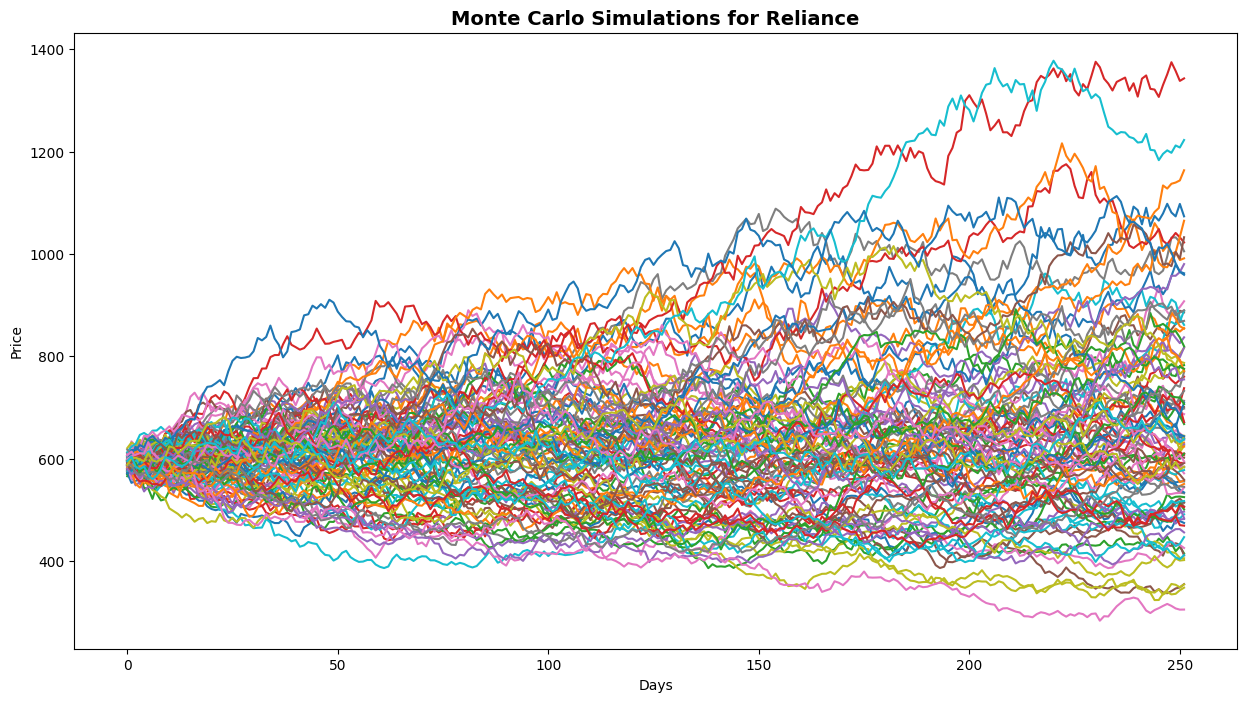

In [38]:
### Setting the s0 as the value of the last close price of reliance
s0 = reliance['Close'].iloc[0]
### Loop through 100 simulations
for i in range(100):
    ## Generate the Random returns, where mu and vol are mean and std of log returns 
    rand_rets = np.random.normal(mu,vol,n_days) + 1

    ## Create the Monte Carlo path 
    forecasted_values = s0*rand_rets.cumprod()

    ## Plot the Monte Carlo path
    plt.plot(range(n_days),forecasted_values)
    # Add title and labels
plt.title("Monte Carlo Simulations for Reliance", fontsize=14, fontweight='bold')
plt.xlabel("Days")
plt.ylabel("Price")

# Save the figure
plt.savefig("Monte_Carlo_Simulations_for_Reliance.png", dpi=300, bbox_inches='tight')

plt.show()


In [33]:
forecasted_values

array([575.04517375, 580.82579813, 558.5277846 , 573.55657806,
       572.90273966, 579.95212572, 585.04155419, 590.92741809,
       609.86903182, 613.30553407, 598.96035493, 606.04495447,
       617.79375436, 625.54781113, 633.58230949, 639.68488464,
       647.57398085, 644.70334424, 650.52925985, 639.74556013,
       661.28499946, 662.07157834, 665.72448228, 659.9732214 ,
       643.99262841, 647.94182089, 633.5387266 , 638.82126916,
       641.76009383, 658.65676471, 650.29067913, 645.62398724,
       655.38379594, 648.75307909, 637.70943548, 637.08655067,
       640.87165899, 645.57590269, 636.29295186, 640.5845255 ,
       618.20116104, 613.62976306, 595.33820196, 590.54359493,
       586.33645944, 573.68407804, 559.82111443, 563.01965261,
       555.78553567, 543.56460243, 564.80513485, 583.58418963,
       578.89028238, 587.15982981, 587.32522015, 594.95855391,
       587.55460672, 589.02821333, 586.88593066, 577.39948776,
       571.6108429 , 562.70865884, 555.20302712, 559.68